In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.special import expit
import pymc3 as pm
import arviz as az

from pymc3.gp.util import plot_gp_dist

import cmdstanpy as stan

from tqdm import tqdm

In [3]:
%load_ext stanmagic

In [4]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

# Data

Data accessible here: https://zenodo.org/record/845873#.WeDg9GhSw2x

In [5]:
df = pd.read_csv("data/cpc2018.csv")

In [6]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)

In [7]:
data = pd.DataFrame({
    "subject": data.SubjID,
    "pA": data.pHa.values,
    "xA0": data.Ha.values,
    "xA1": data.La.values,
    "pB": data.pHb.values,
    "xB0": data.Hb.values,
    "xB1": data.Lb.values,
    "y": data.B.values
})
max_x = np.max(np.concatenate((data.xA0, data.xA1, data.xB0, data.xB1)))
data.xA0, data.xA1, data.xB0, data.xB1 = data.xA0/max_x, data.xA1/max_x, data.xB0/max_x, data.xB1/max_x

In [8]:
data

,subject,pA,xA0,xA1,pB,xB0,xB1,y
25,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
26,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
27,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
28,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
29,10100,1.0,0.019802,0.019802,0.5,0.029703,0.009901,0
...,...,...,...,...,...,...,...,...
510395,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510396,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510397,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0
510398,71109,1.0,0.188119,0.188119,0.1,0.960396,0.049505,0


In [10]:
# print(sorted(data.pA.unique()))
# print(sorted(data.pB.unique()))
# print(sorted(data.xA0.unique()))
# print(sorted(data.xA1.unique()))
# print(sorted(data.xB0.unique()))
# print(sorted(data.xB1.unique()))

# CPT fit

In [11]:
def u_pow(x, theta): return x**theta

def u_exp(x, theta): return 1 - np.exp(-theta*x) if isinstance(x, np.ndarray) else 1 - jnp.exp(-theta*x)

def lin(x, theta): return x

def prelec(p, theta): return np.exp(-(-np.log(p))**theta) if isinstance(p, np.ndarray) else jnp.exp(-(-jnp.log(p))**theta)

In [12]:
def softplus(x):
    return np.log(np.exp(x) + 1)

def objective(data, u, w):
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 
    
    def run(param):
        
        tau = softplus(param[0])
        theta_u = softplus(param[1])
        
        if w is not None:
            theta_w = expit(param[2])
            wpA = w(pA, theta_w)
            wpB = w(pB, theta_w)
        
        else:
            wpA = pA
            wpB = pB
        
        uxA0 = u(xA0, theta_u)
        uxA1 = u(xA1, theta_u)
        uxB0 = u(xB0, theta_u)
        uxB1 = u(xB1, theta_u)

        seuA = wpA * uxA0 + (1-wpA) * uxA1
        seuB = wpB * uxB0 + (1-wpB) * uxB1

        diff_seu = seuB - seuA

        p_choice_B = scipy.special.expit(tau*diff_seu)
        p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)

        lls = np.log(p_choice_y + np.finfo(float).eps).sum()
        return - lls
    return run

def optimize(data, u=u_pow, w=None, seed=12345):
    np.random.seed(seed)
    if w is None:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(2))
        theta_w = None
    else:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(3))
        theta_w = expit(opt.x[2])
        
    tau = softplus(opt.x[0])
    theta_u = softplus(opt.x[1])
    return tau, theta_u, theta_w

In [13]:
optimize(data)

(26.720759439803953, 0.8174693045702498, None)

# Model discrepancy

In [14]:
%%stan -f sparse_gp_cpc.stan -v sparse_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
functions {
  vector u_pow(vector x, real theta) {
    return pow(x, theta); 
  }
} 

data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong_A0[N_y];
  int belong_A1[N_y];
  int belong_B0[N_y];
  int belong_B1[N_y];
  real theta;
  real tau;
  real jitter;
  int M;
  // int<lower=0, upper=1> u_model_index;
}
transformed data {
  matrix[M, M] diag_jitter;
  diag_jitter = diag_matrix(rep_vector(jitter, M));
  real X_array[N];
  X_array = to_array_1d(X);
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[M] eta;
  vector<lower=0, upper=1>[M] Xm;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seuA;
  vector[N_y] seuB;
  vector[N] Mp;
  vector[N] f_predict;
  vector[N_y] diff_eu;
  matrix[M, M] L;
  matrix[M, M] K;
  vector[M] f;
  matrix[M, N] K_mp;
  vector[M] Mm;
  vector[M] L_dot_eta;
  matrix[M, N] A;
  vector[M] v;
  
  matrix[M, M] K_factor;
  matrix[M, N] K_mp_factor;
  
  real Xm_array[M];
  
  Xm_array = to_array_1d(Xm);
  
  kernel_length ~ normal(1, 1);
  kernel_var ~ normal(1, 1);
  eta ~ std_normal();
  Xm ~ uniform(0, 1);
  
  // if (u_model_index == 0) {
  //  Mm = Xm;
  //  Mp = X;
  // }
  // else if (u_model_index == 1) {
  //  Mm = u_pow(Xm, theta);
  //  Mp = u_pow(X, theta);
  //}
  //else {
  //  reject("u_model_index incorrect", u_model_index);
  //}
  Mm = u_pow(Xm, theta);
  Mp = u_pow(X, theta);
  
  K_factor = Mm*Mm';
  K_mp_factor = Mm*Mp';

  K = K_factor .* gp_exp_quad_cov(to_array_1d(Xm), kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);

  L_dot_eta = L*eta;
  f = Mm + L_dot_eta;

  K_mp = K_mp_factor .* gp_exp_quad_cov(Xm_array, X_array, kernel_var, kernel_length);
  A = mdivide_left_tri_low(L, K_mp);
  v = mdivide_left_tri_low(L, L_dot_eta);

  f_predict = Mp + A' * v;

  seu = p .* f_predict;
  seuA = seu[belong_A0]+seu[belong_A1];
  seuB = seu[belong_B0]+seu[belong_B1];
  diff_eu = seuB - seuA;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/c8abc208-c949-462f-b042-9e255edff96d.cpp sparse_gp_cpc.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in sparse_model object.
Type sparse_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
sparse_model.model_file -> Name of stan_file [sparse_gp_cpc.stan]
sparse_model.model_name -> Name of stan model [sparse_gp_cpc_model]
sparse_model.model_code -> Model code [functions {   vector ....]


In [15]:
stan_sparse_model = stan.CmdStanModel(stan_file=sparse_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_cpc
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_cpc


In [27]:
def prepare_data_for_stan_sparse(data, tau, theta, M=50):

#     try:
#         u_model_index = {u_lin: 0, u_pow: 1}[u]
#     except KeyError:
#         raise ValueError(f"Utility function {u.__name__} not recognized")
    
    pA = data.pA.values
    pB = data.pB.values

    xA0 = data.xA0.values
    xA1 = data.xA1.values

    xB0 = data.xB0.values
    xB1 = data.xB1.values

    y = data.y.values 

    x = np.hstack((xA0, xA1, xB0, xB1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    init_order = np.argsort(x_order)

    p_sorted = np.hstack((pA, 1-pA, pB, 1-pB))[x_order]
    
    N_x = len(x)
    N_y = len(y)
    
    belong_A0, belong_A1, belong_B0, belong_B1  = init_order.reshape((4, N_y))

    return {
        'tau': tau,
        'theta': theta,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': N_y,
        'N': N_x,
        'jitter': 1e-06,
        'belong_A0': belong_A0 + 1,
        'belong_A1': belong_A1 + 1,
        'belong_B0': belong_A0 + 1,
        'belong_B1': belong_A1 + 1,
        'M': M,
        # 'u_model_index': u_model_index
    } 

In [28]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def sparse_gp_predict(Xnew, samples_az, u, theta, jitter=1.0e-6, use_ratio=True):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_sp = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_sp = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_sp = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    Xm_sp = np.array(samples_az.posterior["Xm"]).reshape(n_sample, -1)
    
    # print(np.isnan(var_samples).any())
    # print(np.isnan(length_samples).any())
    # print(np.isnan(eta_samples).any())
    N = Xnew.shape[0]
    f_predict = np.zeros((n_sample, N))
    
    for i in tqdm(range(n_sample)):
    
        var = var_sp[i]
        length = length_sp[i]
        eta = eta_sp[i] 
        X = Xm_sp[i]
        
        uX = u(X, theta)
        
        if use_ratio:
            factor = uX[:, None] * uX
        else:
            factor = 1
        
        M = X.shape[0]
        
        k_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(M)
        L = np.linalg.cholesky(k_XX)
        L_dot_eta = L.dot(eta)
        f = uX + L_dot_eta


        up = u(Xnew, theta)
        if use_ratio:
            factor_Xp = uX[:, None] * up
        else:
            factor_Xp = 1
        
        K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)

        A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

        f_predict[i] = up + A.T.dot(v)

    return f_predict

In [29]:
np.random.seed(1234)
data_gp = data.sample(200)

In [30]:
opt_param = optimize(data_gp, u=u_pow, w=None)
tau = opt_param[0]
theta_u = opt_param[1]
theta_w = opt_param[2]
print(f"tau={tau}, theta_u={theta_u}", f"theta_w={theta_w}")

tau=34.44655122208853, theta_u=0.8822211886515096 theta_w=None


In [32]:
stan_sparse_data = prepare_data_for_stan_sparse(
    data_gp, tau=tau, theta=theta_u)

In [33]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
samples_az = az.from_cmdstanpy(trace)

In [40]:
x_plot = np.linspace(0, 1, 100)
f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                              u=u_pow, theta=theta_u,
                              use_ratio=True)

100%|██████████| 2000/2000 [00:01<00:00, 1972.14it/s]


In [44]:
uX = u_pow(x_plot, theta=theta_u)

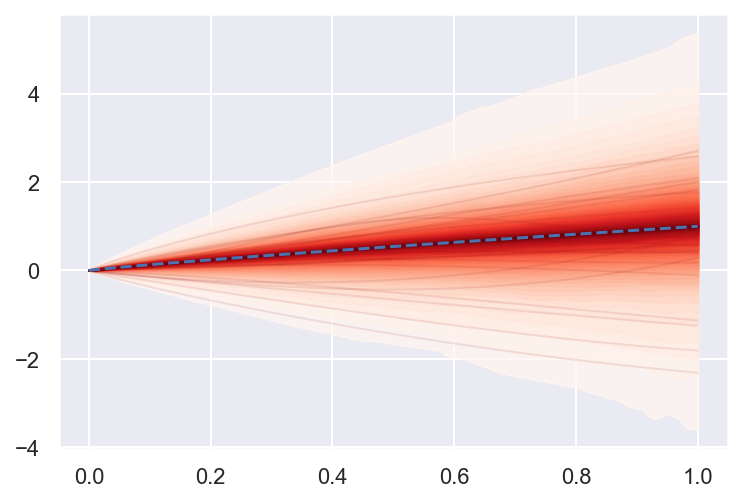

In [45]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
ax.plot(x_plot, uX, ls="--");

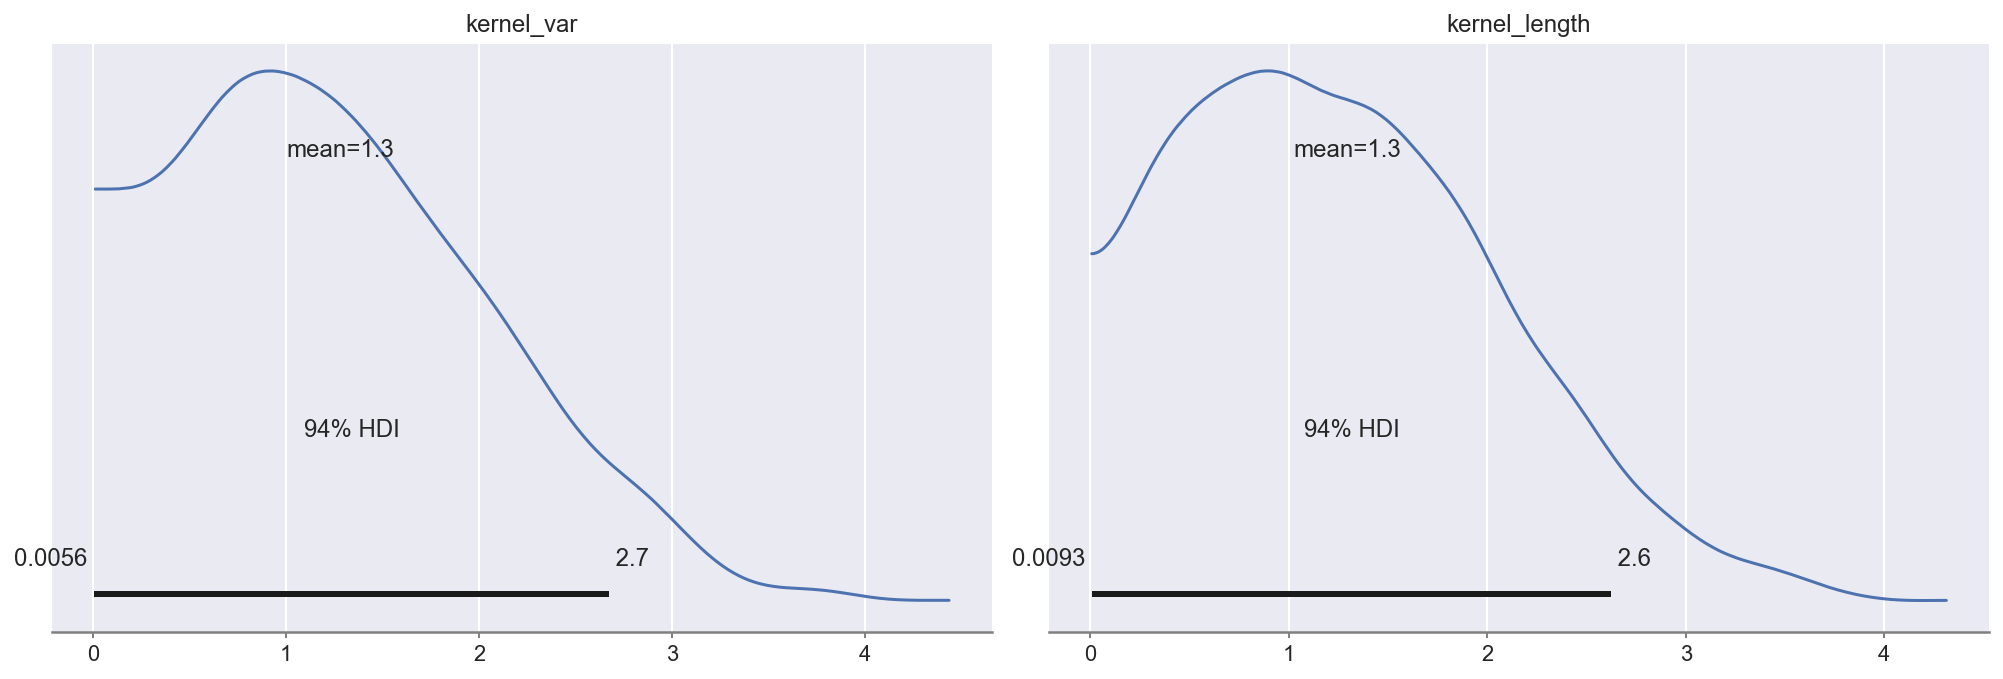

In [42]:
az.plot_posterior(samples_az, var_names=["kernel_var", "kernel_length"]);

In [43]:
trace.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpyql3re9j/sparse_gp_cpc-202104141313-1-v_c8q3uy.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpyql3re9j/sparse_gp_cpc-202104141313-2-y37q81o6.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpyql3re9j/sparse_gp_cpc-202104141313-1-v_c8q3uy.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpyql3re9j/sparse_gp_cpc-202104141313-2-y37q81o6.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [46]:
r = (f_samples+1e-06) / (uX + 1e-06)

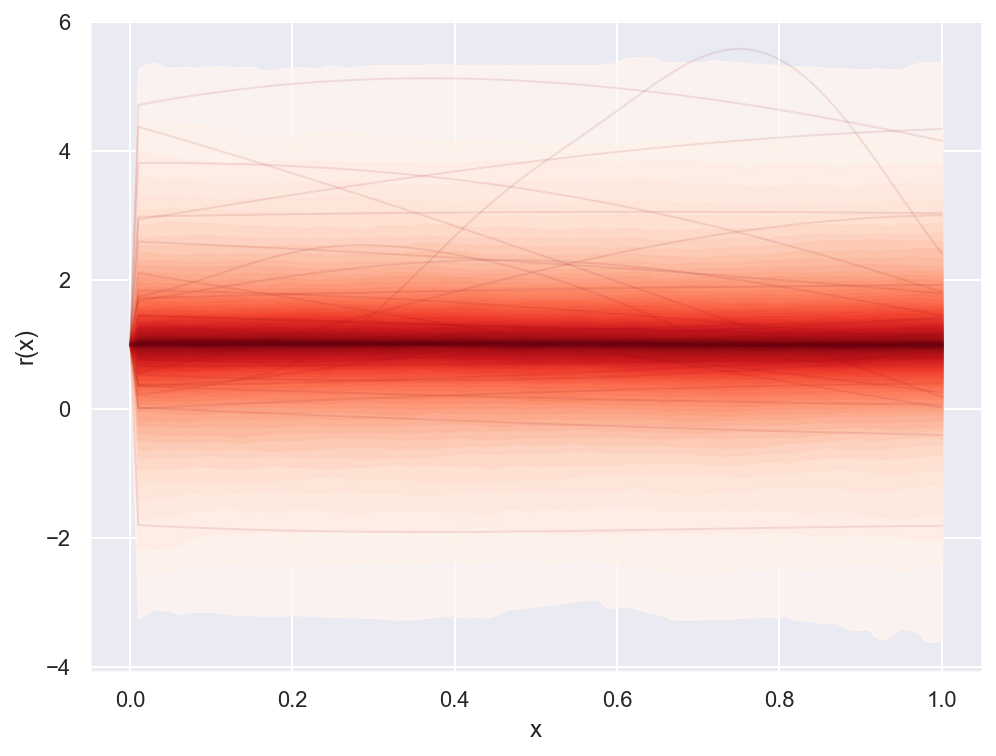

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_plot)
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

# Individual fit

In [50]:
counts = data.subject.value_counts()
subject_325 =  counts[counts == 325].index
print(subject_325)

Int64Index([11303, 10113, 10316, 11603, 11020, 11315, 11309, 11027, 10355,
            10342,
            ...
            10107, 11322, 11328, 11007, 11008, 11002, 11327, 10104, 10116,
            11302],
           dtype='int64', length=125)


In [ ]:
r = []

for s in subject_325:
    d = data[data.subject == s]

    opt_param = optimize(d, u=u_pow, w=None)
    tau = opt_param[0]
    theta_u = opt_param[1]
    
    stan_sparse_data = prepare_data_for_stan_sparse(d, tau=tau, theta=theta_u)

    trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

    samples_az = az.from_cmdstanpy(trace)
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] \
        * samples_az.posterior["kernel_var"].shape[1]
    
    var_sp = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_sp = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_sp = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    Xm_sp = np.array(samples_az.posterior["Xm"]).reshape(n_sample, -1)
    

    x_plot = np.linspace(0, 1, 100)
    f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                                  u=u_pow, theta=theta_u,
                                  use_ratio=True)
    r.append(dict(
        subject=s,
        theta_u=theta_u,
        tau=tau,
        var=var_sp,
        length=length_sp,
        eta=eta_sp,
        Xm=Xm_sp,
        f=f_samples,
    ))
    
    uX = u_pow(x_plot, theta=theta_u)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f"Subject {s}")
    plot_gp_dist(ax, f_samples, x_plot)
    ax.plot(x_plot, uX, ls='--', color='C0', label="prior")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.legend()
    plt.show()

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]